### TVLA using min-$p$ as a performance measure.

In [1]:
import numpy as np
import psutil
from numpy.testing import assert_equal, assert_almost_equal
from scipy.stats import t as stats_t
from scipy.stats import ttest_ind
import seaborn as sns

In [2]:
from tqdm import tqdm
from src.tools.plotter import plot_p_gradient, plot_accu
def make_t_test(n: int):
    """
    Returns a t-test that takes the sample mean and variance for a list of sample points from A, and a list of sample
    points for B.
    """
    n_sqrt = np.sqrt(n)
    nmm = n - 1

    def welch_t_test(a: np.array, b: np.array):
        mean_a, var_a = a
        mean_b, var_b = b

        # Prevent division by 0 errors
        var_a += .001
        var_b += .001

        m = mean_a - mean_b
        s = np.sqrt(var_a + var_b) / n_sqrt

        t = m / s

        dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)

        p = 2 * stats_t(df=dof).cdf(-np.abs(t))

        return t, p

    return welch_t_test

In [3]:
TRACE_LEN = 1400

def gen_example(mean, trace_num, trace_len=TRACE_LEN):
    return np.random.normal(mean, 2.2, size=(trace_num, trace_len)).astype(np.uint8)

def gen_random(mean_a, mean_b, trace_num, trace_len=TRACE_LEN):
    ex_random = np.array([gen_example(mu, trace_num) for mu in [mean_a, mean_b]]).reshape(2 * trace_num, trace_len)
    np.random.shuffle(ex_random)

    return ex_random[NUM_TRACES:], ex_random[:NUM_TRACES]

def get_mv(x: np.array):
    return np.array((x.mean(axis=0), x.var(axis=0)))

NUM_TRACES = 1000

ex_a1 = gen_example(80, NUM_TRACES)
ex_a2 = gen_example(80, NUM_TRACES)
ex_b1 = gen_example(81, NUM_TRACES)
ex_r1, ex_r2 = gen_random(80, 81, NUM_TRACES)

In [4]:
res_sp = ttest_ind(ex_a1, ex_b1, axis=0, equal_var=False)[1]

res_sp[:5]

array([4.97554716e-27, 1.24098909e-29, 9.40616605e-20, 3.88406635e-22,
       1.81863500e-24])

In [5]:
test = make_t_test(NUM_TRACES)

res_custom = test(get_mv(ex_a1), get_mv(ex_b1))[1]

res_custom[:5]

array([4.75330209e-27, 1.18090181e-29, 9.10296144e-20, 3.74383374e-22,
       1.74499901e-24])

In [6]:
ex_test_aa = np.min(test(get_mv(ex_a1), get_mv(ex_a2))[1])
ex_test_ab = np.min(test(get_mv(ex_a1), get_mv(ex_b1))[1])

ex_test_aa, ex_test_ab

(2.2025790360955024e-05, 4.055601944761154e-39)

$\sigma^2=\frac{1}{N}\underset{i=1}{\overset{N}{\sum}}{x_i^2-\mu^2} =
\underset{i=1}{\overset{N}{\sum}}{(\frac{x_i^2}{N}-\frac{\mu^2}{N})}$

In [7]:
class Accu:
    def __init__(self, trace_len: int):
        self.n = 0
        self.mean = np.zeros(trace_len, dtype=np.float128)
        self.var = np.zeros(trace_len, dtype=np.float128)
        self.cm = np.zeros(trace_len, dtype=np.float128)

    def add(self, trace):
        self.n += 1

        if self.n > 1:
            self.mean += (-self.mean + trace) / self.n
        else:
            self.mean = trace

        self.cm += (-self.cm + np.power(trace, 2)) / self.n
        self.var = self.cm - np.power(self.mean, 2)

    def get_mean(self):
        return self.mean.astype(np.float64)

    def get_var(self):
        return self.var.astype(np.float64)


# acc = Accu(ex_a.shape[1])
# [acc.add(ex_a[i]) for i in range(len(ex_a))]
#
# acc.get_var(), ex_a.var(axis=0)

In [8]:
ns = np.repeat(1 / np.arange(1, len(ex_a1) + 1)[:, np.newaxis], ex_a1.shape[1], axis=1)
cs_mean = np.cumsum(ex_a1, axis=0) * ns

cs_mean[-1][:5], ex_a1.mean(axis=0)[:5]

(array([79.435, 79.424, 79.533, 79.55 , 79.505]),
 array([79.435, 79.424, 79.533, 79.55 , 79.505]))

In [9]:
x2 = np.cumsum(np.power(ex_a1, 2) - np.power(cs_mean, 2), axis=0) * ns
x2[-1][:5], ex_a1.var(axis=0)[:5]

(array([-6206.24997343, -6187.79536438, -6216.93735429, -6226.9056282 ,
        -6224.79046969]),
 array([5.201775, 4.880224, 4.652911, 4.8155  , 5.239975]))

In [10]:
def mv_cumsum(a):
    a = a.astype(np.float128)
    n = np.repeat(np.arange(1, len(a) + 1)[:, np.newaxis], a.shape[1], axis=1).astype(np.float128)

    a_mean = np.cumsum(a, axis=0) / n
    a_var = np.cumsum(np.power(a, 2), axis=0) / n - np.power(a_mean, 2)

    return np.array([a_mean.astype(np.float64), a_var.astype(np.float64)])

def p_gradient(a, b):
    trace_len = a.shape[1]
    assert trace_len == b.shape[1]

    max_traces = max(len(a), len(b))
    mv_a, mv_b = mv_cumsum(a), mv_cumsum(b)

    res = np.ones(max_traces)
    min_res = 1
    for i in tqdm(range(1, max_traces)):
        t_test = make_t_test(i+1)
        min_res = min(min_res, np.min(t_test(mv_a[:, i], mv_b[:, i])[1]))

        res[i] = min_res

    return res

mv_cumsum(ex_a1)[1][-1], ex_a1.var(axis=0)

(array([5.201775, 4.880224, 4.652911, ..., 4.7111  , 4.853536, 4.709984]),
 array([5.201775, 4.880224, 4.652911, ..., 4.7111  , 4.853536, 4.709984]))

100%|██████████| 999/999 [00:00<00:00, 1171.17it/s]


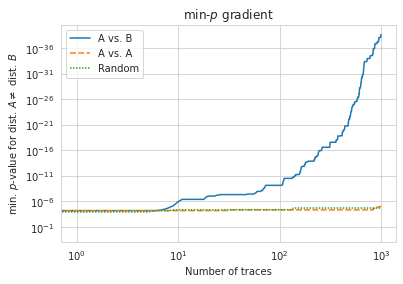

In [11]:
plot_p_gradient({
    "A vs. B": p_gradient(ex_a1, ex_b1),
    "A vs. A": p_gradient(ex_a1, ex_a2),
    "Random": p_gradient(ex_r1, ex_r2),
})

100%|██████████| 999/999 [00:00<00:00, 1075.94it/s]


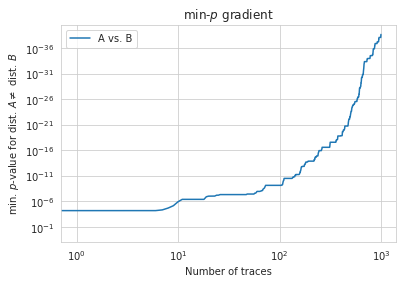

In [12]:
plot_p_gradient({
    "A vs. B": p_gradient(ex_a1, ex_b1),
})

In [13]:
class CSAccu:
    # For future enhancement, __add_batch only has the mean and variance calculated.
    num_moments = 2
    # Two types: A and B.
    num_types = 2
    # Maximum percentage of available memory that I can use.
    max_mem = .5

    def __init__(self, trace_len, make_test=make_t_test, show_progress=True):
        self.n = 0
        self.central_moments = np.zeros((self.num_types, self.num_moments + 1, trace_len), dtype=np.float128)
        self.p_gradient = [1]

        self.make_test = make_test
        self.trace_len = trace_len
        self.show_progress = show_progress
        self.last = [None, None]
        self.progress = None

    def add(self, a, b):
        free_mem = psutil.virtual_memory().available
        mem_unit = a.astype(np.float128).nbytes

        # Add batch costs about 3 #moments + index memory units.
        est_mem_use = mem_unit * (3 * self.num_moments + 1)
        est_frac = est_mem_use / (free_mem * self.max_mem)

        total_size = len(a)
        batches = np.append(np.arange(0, total_size, total_size/np.ceil(est_frac)), [total_size]).astype(int)

        title = f"Performing t-tests ({len(batches)} batches)."
        if self.show_progress:
            self.progress = tqdm(total=len(a) + 1 + len(batches) * self.num_moments, desc=title)

        if len(batches) > 1:
            for i, j in zip(batches[:-1], batches[1:]):
                self.__add_batch(a[i:j], b[i:j])
        else:
            self.__add_batch(a, b)

        if self.show_progress:
            self.progress.close()

    def __add_batch(self, a, b):
        batch_size = len(a)
        assert batch_size == len(b) > 0

        mv_a = self.__add_type_batch(a, 0)
        mv_b = self.__add_type_batch(b, 1)

        new_n = self.n + batch_size

        min_p = self.p_gradient[-1]

        for i in range(int(self.n == 0), batch_size):
            stat_test = self.make_test(self.n + i + 1)

            sample_ts, sample_ps = stat_test(mv_a[:, i], mv_b[:, i])

            min_p = min(min_p, np.min(sample_ps))
            self.p_gradient.append(min_p)

            if self.show_progress:
                self.progress.update(1)

        self.n = new_n

    def __add_type_batch(self, x, batch_type):
        has_iv = self.n > 0
        n = self.n

        x = x.astype(np.float128)

        ix_start = n - int(has_iv) + 1
        ix_end = n + len(x) + 1

        ixs = np.repeat(np.arange(ix_start, ix_end)[:, np.newaxis], self.trace_len, axis=1)

        def prepend(arr, moment):
            if has_iv:
                cm_selected = self.central_moments[batch_type][moment]

                return np.append(arr=[cm_selected], values=arr, axis=0)
            return arr

        # Central statical moments.
        cms = np.zeros((self.num_moments + 1, *ixs.shape), dtype=np.float128)

        for i in range(self.num_moments + 1):
            cms[i] = np.cumsum(prepend(np.power(x, i), i), axis=0)
            if self.show_progress:
                self.progress.update(1)

        # This might be extended to higher order statistical moments in the future.
        x_mean = cms[1] / ixs
        x_var = cms[2] / ixs - np.power(x_mean, 2)

        self.last[batch_type] = np.array((x_mean[-1], x_var[-1]), dtype=np.float64)

        # New central moment is the central moment after inserting the last trace from this batch.
        self.central_moments[batch_type] = np.array(cms)[:, -1]

        # This might be extended to higher order statistical moments in the future.
        res = np.array((x_mean, x_var), dtype=np.float64)

        return res

In [14]:
acc = CSAccu(ex_a1.shape[1])
acc.add(ex_a1, ex_b1)

assert_equal(acc.last[0][0], ex_a1.mean(axis=0))
assert_equal(acc.last[1][0], ex_b1.mean(axis=0))
assert_almost_equal(acc.last[0][1], ex_a1.var(axis=0))
assert_almost_equal(acc.last[1][1], ex_b1.var(axis=0))

Performing t-tests (2 batches).: 100%|██████████| 1005/1005 [00:01<00:00, 757.44it/s]


In [15]:
# acc2 = CSAccu(ex_a1.shape[1], show_progress=False)
# [acc2.add(np.array([ex_a1[i]]), np.array([ex_a1[i]])) for i in range(0, NUM_TRACES)]
#
# assert_equal(acc2.last[0][0], ex_a1.mean(axis=0))
# assert_equal(acc2.last[1][0], ex_b1.mean(axis=0))
#
# assert_almost_equal(acc2.last[0][1], ex_a1.var(axis=0))
# assert_almost_equal(acc2.last[1][1], ex_b1.var(axis=0))

# TODO

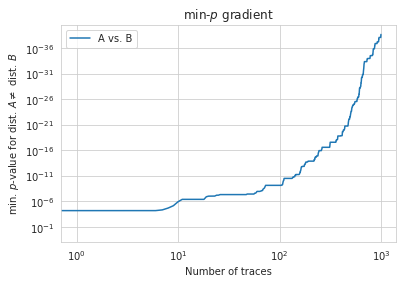

In [16]:
plot_accu({"A vs. B": acc})